# **IS-LM model**

**Imports and set magics**

In [1]:
import numpy as np
from scipy import optimize
import sympy as sm
import matplotlib.pyplot as plt

# autoreload modules when code is run
%load_ext autoreload
%autoreload 2

# Model description

The IS-LM model describes the relationship between interest rates, $r$, and output, $Y$. It is made up of an investment-savings curve (IS), explaining the goods market and liquidity-money curve (LM), explaining the money market. Together they make up the demand of the economy.

The IS curve is explained by the functions:
$$PE=C+I+G$$
$$Y=PE$$
$$C=a+b*(Y-T)$$
$$I=c-d*r$$

Where $C$ is Consumption, $I$ is investment, $G$ is government spending, $Y$ is GDP, $T$ is taxes, and $PE$ is planned expenditure known from the Keynesian cross. In case of equilibrium in the goods market we get $PE=Y$.

$a, b, c, d$ are positive parameters with $b<1$.

The LM curve is explained by:
$$\frac{M}P=L$$
$$L=e*Y-f*r$$

Where $\frac{M}P$ is the real money supply, $L$ is the demand for money, and $r$ is interest rate.

$e, f$ are positive parameters.

In [2]:
#Define the variables
PE = sm.symbols("PE")
Y = sm.symbols("Y")
C = sm.symbols("C")
I = sm.symbols("I")
G = sm.symbols("G")
a = sm.symbols("a")
b = sm.symbols("b")
T = sm.symbols("T")
c = sm.symbols("c")
d = sm.symbols("d")
r = sm.symbols("r")
M = sm.symbols("M")
P = sm.symbols("P")
L = sm.symbols("L")
e = sm.symbols("e")
f = sm.symbols("f")


# Analytical solution

I first display the functions using sympy:

In [3]:
# create functions for IS curve
PlannedExpenditure = sm.Eq(PE,C+I+G)
GDP = sm.Eq(Y,PE)
Consumption = sm.Eq(C,a+b*(Y-T))
Investment = sm.Eq(I,c-d*r)
display(PlannedExpenditure)
display(GDP)
display(Consumption)
display(Investment)

# create functions for LM curve
Moneysupply = sm.Eq(M/P,L)
Moneydemand = sm.Eq(L,e*Y-f*r)
display(Moneydemand)
display(Moneysupply)

Eq(PE, C + G + I)

Eq(Y, PE)

Eq(C, a + b*(-T + Y))

Eq(I, c - d*r)

Eq(L, Y*e - f*r)

Eq(M/P, L)

Solving for r in the IS and LM curves we get the relationship as:

In [4]:
#solves the IS function wrt. r
sol_IS = sm.solve([PlannedExpenditure,GDP,Consumption,Investment],[r,I,C,PE])
#solves the LM function wrt. r
sol_LM = sm.solve([Moneysupply,Moneydemand],[r,L])

#display IS and LM
solved_IS = sm.Eq(sol_IS[r],r)
print("IS:")
display(sm.simplify(solved_IS))
sol_LM = sm.solve([Moneysupply,Moneydemand],[r,L])
solved_LM = sm.Eq(sol_LM[r],r)
print("LM:")
display(sm.simplify(solved_LM))

IS:


Eq(r, (G - T*b + Y*b - Y + a + c)/d)

LM:


Eq(r, (-M + P*Y*e)/(P*f))

Combining the 2 will net us the aggregate demand for the economy in terms of output, $Y$.

In [5]:
# solves the IS and LM curves and isolates Y
sol_AD = sm.solve([solved_IS,solved_LM],[Y,r])

# display AD
print("AD:")
print("Y =")
display(sm.simplify(sol_AD[Y]))


AD:
Y =


(G*P*f + M*d - P*T*b*f + P*a*f + P*c*f)/(P*(-b*f + d*e + f))

In [6]:
# characterize the solution by lambdifying 
IS_lambdify = sm.lambdify(args=(Y,G,T,a,b,c,d),expr=sol_IS[r])
LM_lambdify = sm.lambdify(args=(Y,M,P,e,f),expr=sol_LM[r])
AD_lambdify = sm.lambdify(args=(G,T,M,P,a,b,c,d,e,f),expr=sol_AD[Y])

# print the solution for given parameter values
print(f'r = {IS_lambdify(AD_lambdify(200,300,1000,1,1000,0.75,50,100,0.25,50),200,300,1000,0.75,50,100):.3}')
print(f'r = {LM_lambdify(AD_lambdify(200,300,1000,1,1000,0.75,50,100,0.25,50),1000,1,0.25,50):.3}')
print(f'Y = {AD_lambdify(200,300,1000,1,1000,0.75,50,100,0.25,50):.7}')


r = 0.167
r = 0.167
Y = 4033.333


Inserting parameter values to:

$G=200, T=300, M=1000, P=1, a=1000, b=0.75, c=50, d=100, e=0.25, f=50$

We get an equilibrium interest of 0.167 and a GDP of 4033.333.

# Numerical solution

I now solve the problem numerically by setting up functions and using scipy.optimize

In [7]:
# IS functions
def IS_num(r,Y=1000,G=200,T=300,a=1000,b=0.75,c=50,d=100):
    PE = Y
    C = a+b*(Y-T)
    I = c-d*r
    eqIS = PE - (C + I + G)
    return eqIS

# LM functions
def LM_num(r,Y=1000,M=1000,P=1,e=0.25,f=50):
    L = e*Y - f*r
    eqLM = M/P - L
    return eqLM

# initial guess for interest rate
r_guess = 1

# use fsolve to find the value of r given the other parameter values
def r_IS_num(Y=1000,G=200,T=300,a=1000,b=0.75,c=50,d=100):
    return optimize.fsolve(IS_num, r_guess, args=(Y,G,T,a,b,c,d))

def r_LM_num(Y=1000,M=1000,P=1,e=0.25,f=50):
    return optimize.fsolve(LM_num, r_guess, args=(Y,M,P,e,f))

# find the AD values by looping through Y values until IS=LM
def AD_num(G=200,T=300,M=1000,P=1,a=1000,b=0.75,c=50,d=100,e=0.25,f=50):
    for o in range(0,1000000,1):
        IS = r_IS_num(Y=o,G=G,T=T,a=a,b=b,c=c,d=d)
        LM = r_LM_num(Y=o,M=M,P=P,e=e,f=f)
        if IS - LM < 1e-8:
            return o
            break # break the loop when the right solution has been found

print(f'Y = {AD_num()}')
print(f'r = {r_IS_num(AD_num())}')
print(f'r = {r_LM_num(AD_num())}')

Y = 4034
r = [0.165]
r = [0.17]


We get similar results to the analytical solution, though these are calculated with integers instead of floats.

We now look at the impact of fiscal- and monetary policy:

In [8]:
# sets up ranges
Spending = range(0,600,200)
Tax = range(0,600,200)
Money = range(2000,8000,2000)

print("Government spending:")
for G in Spending:
    print(f'G = {G:4}, Y = {AD_num(G=G)}')

print("Lump sum tax:")
for T in Tax:
    print(f'T = {T:4}, Y = {AD_num(T=T)}')

print("Money supply:")
for M in Money:
    print(f'M = {M:4}, Y = {AD_num(M=M)}')


Government spending:
G =    0, Y = 3767
G =  200, Y = 4034
G =  400, Y = 4300
Lump sum tax:
T =    0, Y = 4334
T =  200, Y = 4134
T =  400, Y = 3934
Money supply:
M = 2000, Y = 6700
M = 4000, Y = 12034
M = 6000, Y = 17367


As expected, government spending as well as increasing money supplu increases demand, while increasing taxes lowers demand.

Using the numerical functions, we now set up graphs:

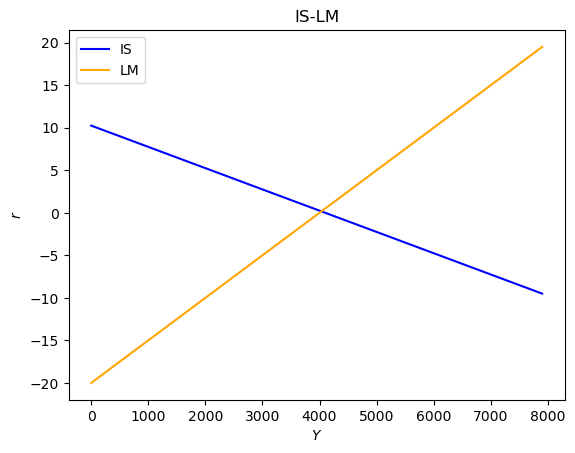

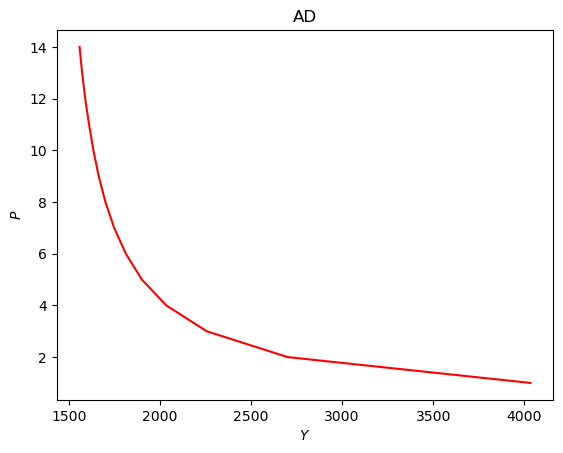

In [9]:
IS_graph_num = []
LM_graph_num = []
AD_graph_num = []
# Y values evaluated for IS-LM graph
Y_vec = np.array(range(0,8000,100))
 # P values evaluated for AD graph
P_vec = np.array(range(1,15,1))

for o in Y_vec:
    r = r_IS_num(Y=o)
    IS_graph_num.append(r)

for o in Y_vec:
    r = r_LM_num(Y=o)
    LM_graph_num.append(r)

for o in P_vec:
    Y = AD_num(P=o)
    AD_graph_num.append(Y)

# create graph for IS-LM
plt.figure()
plt.title("IS-LM")
plt.ylabel("$r$")
plt.xlabel("$Y$")
plt.plot(Y_vec,IS_graph_num, label="IS", color='blue')
plt.plot(Y_vec,LM_graph_num, label="LM", color='orange')
plt.legend()

# create graph for AD
plt.figure()
plt.title("AD")
plt.ylabel("$P$")
plt.xlabel("$Y$")
plt.plot(AD_graph_num, P_vec, label="AD", color='red')
plt.show()

We observe a downward sloping IS curve and upward sloping LM curve.

For the AD curve we see that it is concave with the demand falling as prices increase

# Model extension: proportional taxrate

I now examine the IS-LM model with a proportional tax as opposed to lump sum.

In [10]:
# new IS side
def t_IS_num(r,Y=1000,G=200,t=0.3,a=1000,b=0.75,c=50,d=100):
    PE = Y
    C = a+b*(Y-t*Y)
    I = c-d*r
    eqIS = PE - (C + I + G)
    return eqIS

# set guess for r
r_guess = 1

# use fsolve to find the value of r given the other parameter values
def t_r_IS_num(Y=1000,G=200,t=0.3,a=1000,b=0.75,c=50,d=100):
    return optimize.fsolve(t_IS_num, r_guess, args=(Y,G,t,a,b,c,d))


# find the AD values by looping through Y values until IS=LM
def t_AD_num(G=200,t=0.3,M=1000,P=1,a=1000,b=0.75,c=50,d=100,e=0.25,f=50):
    for o in range(0,1000000,1):
        IS = t_r_IS_num(Y=o,G=G,t=t,a=a,b=b,c=c,d=d)
        LM = r_LM_num(Y=o,M=M,P=P,e=e,f=f)
        if IS - LM < 1e-8:
            return o
            break

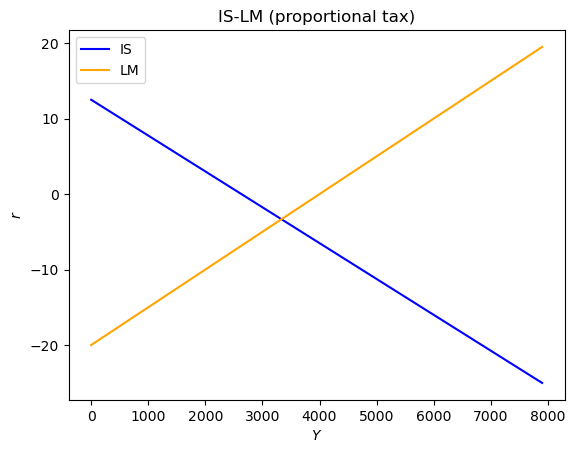

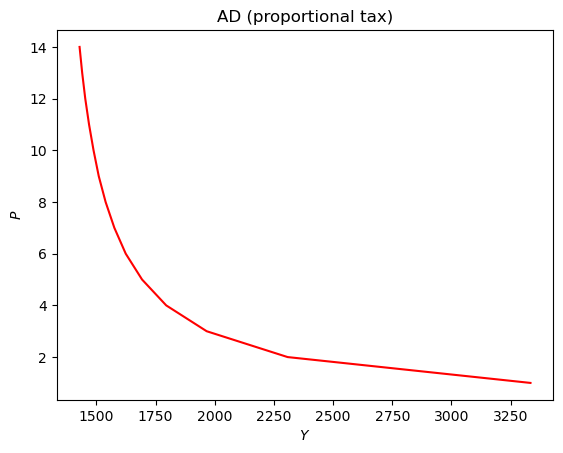

In [11]:
t_IS_graph_num = []
t_AD_graph_num = []

for o in Y_vec:
    r = t_r_IS_num(Y=o)
    t_IS_graph_num.append(r)

for o in P_vec:
    Y = t_AD_num(P=o)
    t_AD_graph_num.append(Y)

# create graph for IS-LM
plt.figure()
plt.title("IS-LM (proportional tax)")
plt.ylabel("$r$")
plt.xlabel("$Y$")
plt.plot(Y_vec,t_IS_graph_num, label="IS", color='blue')
plt.plot(Y_vec,LM_graph_num, label="LM", color='orange')
plt.legend()

# create graph for AD
plt.figure()
plt.title("AD (proportional tax)")
plt.ylabel("$P$")
plt.xlabel("$Y$")
plt.plot(t_AD_graph_num, P_vec, label="AD", color='red')
plt.show()


By incorporating a proportional tax, you see that the demand of the economy decreases. This will be the case for instances where the economy is in a boom, while if it is in recession, it will be relatively higher than the lump sum variant.

The proportional tax thus helps stabilize the economy automatically.

# Conclusion

As expected, we find a negative sloping IS curve and an positive sloping LM curve, as well as the aggregate demand decreasing as prices increase.

It is clear, that the government can use fiscal and monetary policies to change the demand of the economy, where an increase in $G$ or $M$ increases demand and $T$ lowers it.

